In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import neural_network
from sklearn import tree
from sklearn import ensemble

from scipy import signal
import warnings
import xgboost as xgb
import catboost as cb
import optuna
from tqdm import tqdm
import joblib

# IO utils


# Data

In [2]:
palm_files = [
    './temp/2024-03-04_08-17-49.emg8',
    './temp/2024-03-04_10-00-21.emg8',
    './temp/2024-03-04_11-11-02.emg8'
]
palm_file = palm_files[1] # change index [0, 1, 2]
gestures = pd.read_csv(palm_file, sep=' ', on_bad_lines='skip')
gestures = gestures[~gestures['state'].isin(['Baseline', 'Finish'])]
gestures.sort_index(inplace=True)
gestures.reset_index(drop=True, inplace=True)

print(gestures.shape)
gestures.head()

(6364, 56)


,ts,td,0,1,2,3,4,5,6,7,...,44,45,46,47,48,49,prot,state,id,now
0,1366859.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.00
1,1366892.0,33.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.04
2,1366925.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.07
3,1366958.0,33.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.10
4,1366991.0,33.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.13


In [3]:
OMG_CH = np.arange(50).astype(str)

In [4]:
# [X features] '0', ..., '49' - каналы OMG датчиков
# 'ts' - метка времени
gestures.columns

Index(['ts', 'td', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', 'prot', 'state', 'id', 'now'],
      dtype='object')

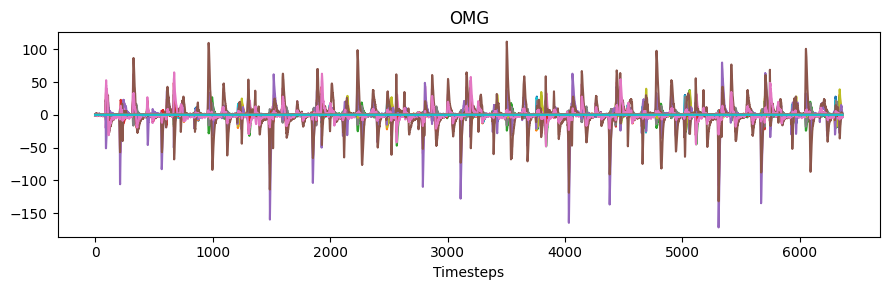

In [5]:
fig = plt.figure(figsize=(9, 3))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

In [6]:
X = gestures[OMG_CH].values

le = preprocessing.LabelEncoder()
state = gestures['state'].values
y_cmd = le.fit_transform(state)

display(np.c_[le.transform(le.classes_), le.classes_])

print(X.shape, y_cmd.shape)

array([[0, 'Close'],
       [1, 'Indication'],
       [2, 'Neutral'],
       [3, 'Open'],
       [4, 'Pinch'],
       [5, 'ThumbFingers']], dtype=object)

(6364, 50) (6364,)


In [7]:
GESTURES = le.classes_
GESTURES

array(['Close', 'Indication', 'Neutral', 'Open', 'Pinch', 'ThumbFingers'],
      dtype=object)

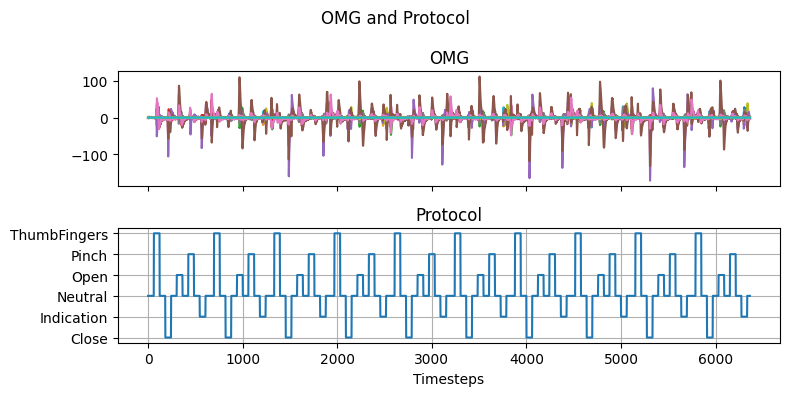

In [8]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.suptitle('OMG and Protocol')
plt.tight_layout()

---
---
---

# Preprocessing

In [9]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.grid(axis='y')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

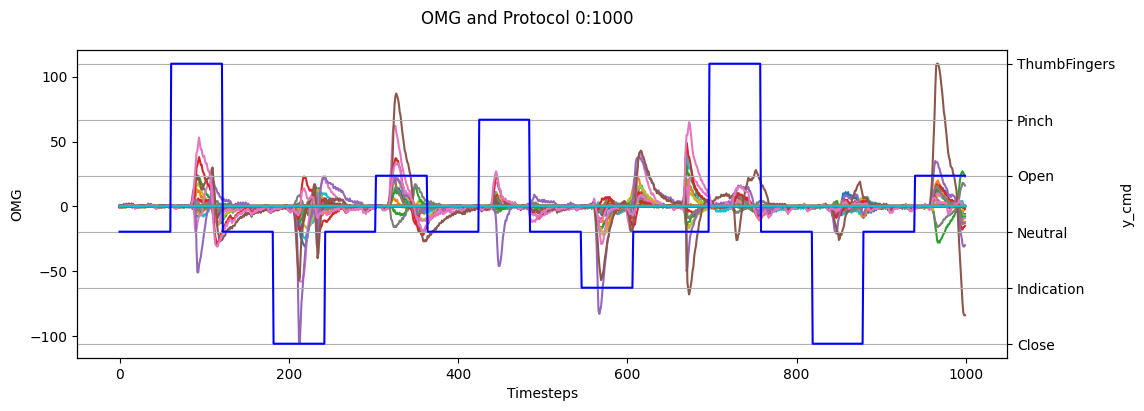

In [10]:
get_graphs(gestures[OMG_CH].values, y_cmd, start=0, end=1000)

Данные с датчиков будто немного отстают от команд. Оператор, что естественно, делает жест с некоторым лагом. Чтобы обучить модель определять тип жеста по данным, нм необходимо немного сдвинуть таргет: это может повысить качество обучающих данных.

## Устранение лага между сигналами датчиков и таргетом

In [11]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [12]:
X = gestures[OMG_CH].values
fitting_model = svm.LinearSVC(dual='auto')
y_shifted, summary = get_naive_centering(X, y_cmd, gap=20, inter=100, use_m=False, model=fitting_model)

print('Test sample shifting\n', *summary, sep='')

Test sample shifting
Оптимальные свдиги для концевых выборок:   20 и 20
Accuracy/correlation на концевых выборках: 0.7544102067448368; 0.5373318229830528
Размер оптимального сдвига (как среднего): 20


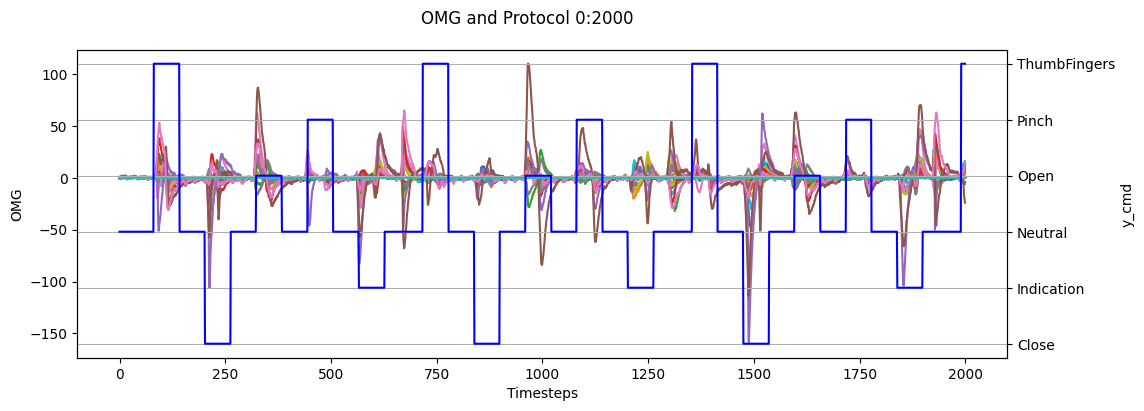

In [13]:
get_graphs(X, y_shifted, start=0, end=2000)

## Сэмплирование

In [14]:
X_train = X[:int(X.shape[0] * 0.8)+1]
X_valid = X[int(X.shape[0] * 0.8)+1:]

y_train = y_shifted[:int(X.shape[0] * 0.8)+1]
y_valid = y_shifted[int(X.shape[0] * 0.8)+1:]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(5092, 50) (5092,)
(1272, 50) (1272,)


## Корреляционный анализ

In [15]:
def find_highly_correlated_features(data, threshold=0.9):
    """Функция корреляционного анализа

    Args:
        data (ndarray): Массив данных.
        threshold (float, optional): Порог корреляции. Defaults to 0.9.

    Returns:
        tuple:
            list: Спсиок пар номеров высоко скореллированных признаков.
            set: Множество оптимально-отобранных номеров признаков из
                высоко скореллированных пар.
    """
    # Строим корреляционную матрицу
    corr_matrix = np.corrcoef(data, rowvar=False)
    
    # Находим индексы нижнего треугольника корреляционной матрицы
    lower_triangle_indices = np.tril_indices(corr_matrix.shape[0], k=-1)
    
    # Находим пары высоко скоррелированных признаков
    high_corr_features = [
        [j, i] for i, j in zip(
            lower_triangle_indices[0], lower_triangle_indices[1]
        ) if abs(corr_matrix[i, j]) > threshold
    ]

    hcf_copy = high_corr_features.copy()
    # Определяем features_to_remove
    features_to_remove = []
    while True:
        dct = {}
        for el in hcf_copy:
            for num in el:
                cnt = 0
                for l in hcf_copy:
                    if (num in l) and (len(l) == 2):
                        cnt += 1
                dct[num] = cnt
        
        if (len(set(dct.values())) == 1) and list(dct.values())[0] == 0:
            break
        
        if not dct:
            break

        num_tb_dltd = max(dct, key=dct.get)
        features_to_remove.append(num_tb_dltd)

        hcf_copy = [
            [x for x in inner_list if x != num_tb_dltd]
            for inner_list in hcf_copy
        ]

    return high_corr_features, list(set(features_to_remove))

In [16]:
# high_corr_features, features_to_remove = find_highly_correlated_features(X_train, threshold=0.9)
# print(high_corr_features)
# print(features_to_remove)
# print(f'Всего отобрано уникальных признаков на удаление: {len(features_to_remove)}')

Однако простое удаление этого ряда признаков нечасто приводит к улучшению качества прогнозирования. Это может быть следствием того, что среди удаляемых признаков могут случайно оказаться те, что хорошо скоррелированы с целевым признаком. Этот момент необходимо исследовать отдельно.

In [17]:
# def find_weakly_correlated_features(features, target, threshold):
#     # Вычисляем коэффициент корреляции для каждого признака
#     corr_values = np.abs(np.corrcoef(features, target, rowvar=False)[:-1, -1])  
#     # Находим индексы признаков с корреляцией ниже порога
#     weakly_correlated_features = np.where(corr_values < threshold)[0]  

#     return weakly_correlated_features

In [18]:
# # Порог корреляции
# threshold = 0.2

# # Поиск плохо скоррелированных признаков
# weakly_corr_fs = find_weakly_correlated_features(X_train, y_train, threshold)
# print(list(weakly_corr_fs))
# print(len(weakly_corr_fs))

Теперь остается найти пересечения между рядами высоко скоррелированных между собой признаков и списком тех, что плохо скоррелированны с целевой переменной.

In [19]:
# bad_features = list(set(weakly_corr_fs) & set(features_to_remove))
# print(bad_features)
# print(len(bad_features))

Но даже столь организованный подбор признаков для удаления может не дасть хороших результатов, и даже ухудшить их.

In [20]:
# X_train_cd = np.delete(X_train, bad_features, axis=1)
# X_valid_cd = np.delete(X_valid, bad_features, axis=1)

## Шумоподавление

In [21]:
# def clean_time_series(data, window_size, threshold):
#     # Применяем скользящее среднее к каждому признаку-вектору в массиве
#     smoothed_data = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'), axis=0, arr=data)

#     # Рассчитываем отклонение от скользящего среднего для каждого признака-вектора
#     deviation = np.abs(data - smoothed_data)

#     # Заменяем отклонения от скользящего среднего медианным значением для каждого признака-вектора
#     clean_data = np.where(deviation > threshold, np.median(data, axis=0), data)

#     return clean_data

In [22]:
# X_train_cleaned = clean_time_series(X_train, 3, 0.8)
# X_valid_cleaned = clean_time_series(X_valid, 3, 0.8)

In [23]:
# get_graphs(X_train_cleaned, y_train, start=0, end=2000)

## Стандартизация

In [16]:
mm_scaler = preprocessing.MinMaxScaler()

rb_scaler = preprocessing.RobustScaler()

std_scaler = preprocessing.StandardScaler()

# X_train_scaled = std_scaler.fit_transform(X_train_cd)
# X_valid_scaled = std_scaler.transform(X_valid_cd)

X_train_scaled = std_scaler.fit_transform(X_train)
X_valid_scaled = std_scaler.transform(X_valid)

# X_train_scaled = rb_scaler.fit_transform(X_train_cleaned)
# X_valid_scaled = rb_scaler.transform(X_valid_cleaned)

# X_train_scaled = mm_scaler.fit_transform(X_train)
# X_valid_scaled = mm_scaler.transform(X_valid)

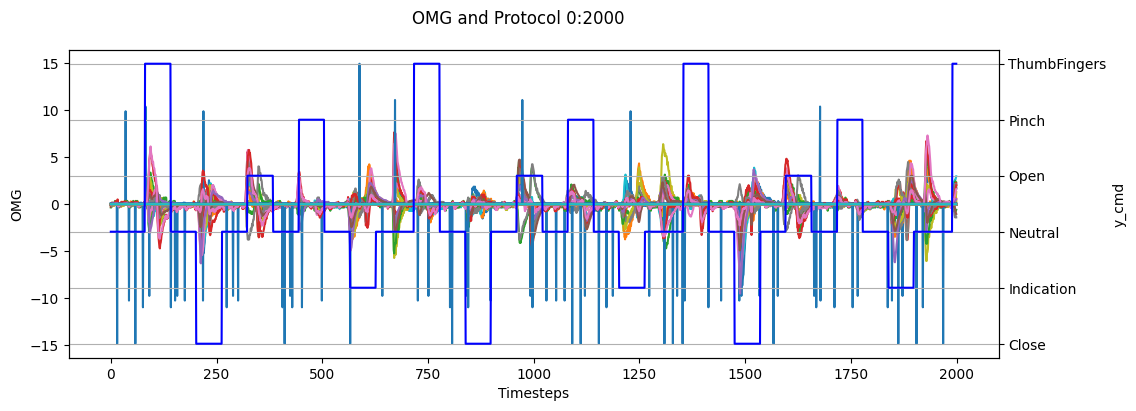

In [17]:
get_graphs(X_train_scaled, y_train, start=0, end=2000)

## Генерация признаков
### Аппроксимирующая модель линейной регрессии

In [26]:
def get_sliding_approximation(X, n_ftrs=10, prev=None, lin_alg=None):
    """Функция для формирования признакового описания 
       с использованием линейной регрессии

    Args:
        X (ndarray): массив данных.
        n_ftrs (int, optional): размер сэмпла. Defaults to 10.
        prev (ndarray, optional): предшествующие данные размером n_ftrs.
        Defaults to None.
        lin_alg (abc.ABCMeta, optional): линейный алгоритм sklearn.
        По умолчанию используется алгоритм МНК из numpy.

    Returns:
        ndarray: массив коэффициентов модели регрессии.
    """
    
    def get_coefs(data):
        # Разделение данных на признаки и целевую переменную
        segments_X = data[1:, :].T
        segments_y = data[0, :]
        
        # Обучение модели линейной регрессии
        if lin_alg is not None:
            model = lin_alg()
            model.fit(segments_X, segments_y)
            # Получение параметров модели
            return model.coef_
        else:
            w = np.linalg.lstsq(segments_X, segments_y, rcond=None)[0]
            # Вектор весов линейной функции
            return w
        
    
    w_g = np.zeros((0, n_ftrs))
    window = np.zeros((n_ftrs+1, X.shape[-1]))
    if prev is not None:
        window[1:, :] = prev
    
    for i in range(X.shape[0]):
        if not np.sum(window[0]):
            window[0, :] = X[i]
        else:
            window[1:, :] = window[:-1, :]
            window[0, :] = X[i]

        coefs = get_coefs(window)
        w_g = np.vstack((w_g, coefs))
    
    return w_g

In [27]:
X_train_approx = get_sliding_approximation(X_train_scaled, n_ftrs=5)
X_valid_approx = get_sliding_approximation(X_valid_scaled, n_ftrs=5)

X_train_approx.shape, X_valid_approx.shape

((5092, 5), (1272, 5))

### Аппроксимирующая модель авторегрессии

In [28]:
def create_AR_features(array, p=5, prev=None):
    """Функция для генерации новых признаков на основе векторов
    оптимальных параметров модели авторегрессии.

    Args:
        array (ndarray): массив данных.
        p (int, optional): размер базы аппроксимации. Defaults to 5.
        prev (ndarray): массив данных для аппроксимации первой точки.
        Defaults to None.

    Returns:
        ndarray: массив сгенерированных признаков на основе
        рассчитанных коэффициентов.
    """
    new_features = np.zeros((array.shape[0],0))
    
    # Проходим внешним циклом по переменным (столбцам) в данных
    for i in range(array.shape[1]):
        if prev is None:
            data = np.hstack((np.zeros(p), array[:, i]))
        else:
            data = np.hstack((prev[:, i], array[:, i]))
        t = len(data)
        w_massive = np.zeros((0, p+1))
        
        # Проходим внутренним циклом по вектору значений переменного
        for j in range(p, t):
            features = data[j-p:j]
            labels = np.array(data[j]).reshape(-1, 1)
        
            # Решение системы уравнений методом наименьших квадратов
            X = np.hstack((np.ones(1), features)).reshape(1, -1)
            w = np.linalg.lstsq(X, labels, rcond=None)[0]
            
            w_massive = np.vstack((w_massive, w.reshape(1, -1)))
            
        # Собираем в единый массив параметры МНК
        new_features = np.hstack((new_features, w_massive))
        
    return new_features

In [29]:
X_train_ar = create_AR_features(X_train_scaled, p=5)
X_valid_ar = create_AR_features(X_valid_scaled, p=5)

X_train_ar.shape, X_valid_ar.shape

((5092, 300), (1272, 300))

---

---

## Выбор типа предобработки

In [771]:
# X_train_new = X_train_scaled
# X_valid_new = X_valid_scaled

# X_train_new = np.hstack((X_train_scaled, X_train_approx))
# X_valid_new = np.hstack((X_valid_scaled, X_valid_approx))

# X_train_new = X_train_ar
# X_valid_new = X_valid_ar

# X_train_new = np.hstack((X_train_approx, X_train_ar))
# X_valid_new = np.hstack((X_valid_approx, X_valid_ar))

X_train_new = np.hstack((X_train_ar, X_train_scaled))
X_valid_new = np.hstack((X_valid_ar, X_valid_scaled))

# X_train_new = np.hstack((X_train_scaled, X_train_approx, X_train_ar))
# X_valid_new = np.hstack((X_valid_scaled, X_valid_approx, X_valid_ar))

## Понижение размерности

In [772]:
# Включаем предупреждениe как исключениe
warnings.simplefilter('error', RuntimeWarning)

# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_new).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])

# Расчет ранга матрицы либо перехват исключения
try:
    matrix_rank = np.linalg.matrix_rank(corr_mtrx)
except Exception as e:
    print('Ошибка:', e)
else:
    print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
    
# Расчет определителя либо перехват предупреждения
try:
    det = np.linalg.det(corr_mtrx)
except RuntimeWarning as rw:
    print(f"""Ошибка вычисления определителя: {rw}
Матрица корреляций является вырожденной""")
else:
    print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 350
Ошибка: SVD did not converge
Ошибка вычисления определителя: invalid value encountered in det
Матрица корреляций является вырожденной


In [773]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_new)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 105


In [774]:
X_train_pca = pca.transform(X_train_new)
X_valid_pca = pca.transform(X_valid_new)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 105
Ранг матрицы:   105
Определитель:   0.9999999999999966


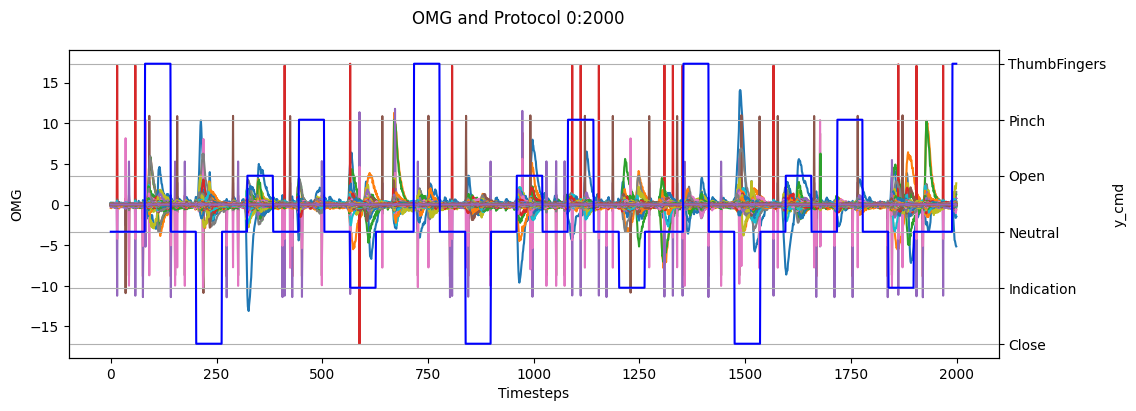

In [775]:
get_graphs(X_train_pca, y_train, start=0, end=2000)

## Экспоненциальное сглаживаение

In [776]:
def get_convolve(data, M=10, tau=3, sym=True):
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [777]:
X_train_ce = get_convolve(X_train_pca, M=10, tau=1, sym=False)
X_valid_ce = get_convolve(X_valid_pca, M=10, tau=1, sym=False)

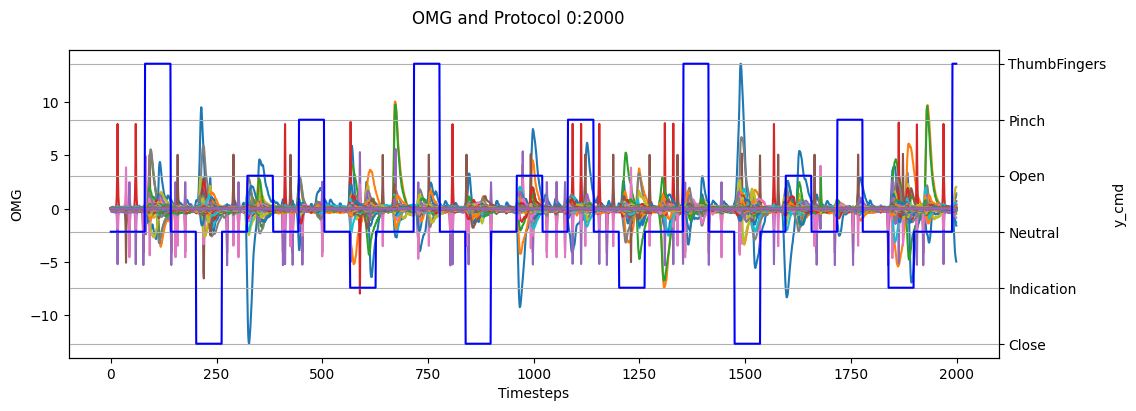

In [778]:
get_graphs(X_train_ce, y_train, start=0, end=2000)

---
---
---

# Modeling

---
### GaussianNB

#### Baseline

In [779]:
model = naive_bayes.GaussianNB()
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.7054202670856246

#### Optimized

In [38]:
# # Определение функции для оптимизации
# def optuna_gnb(trial):
#     """Функция, обучающая модель GaussianNB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1)
    
#     # Инициализация GaussianNB с оптимизируемыми гиперпараметрами
#     clf = naive_bayes.GaussianNB(
#         var_smoothing=var_smoothing
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_gnb = optuna.create_study(study_name="gnb_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=1000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_gnb.optimize(optuna_gnb, n_trials=1000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_gnb.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = naive_bayes.GaussianNB(**study_gnb.best_params)
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [39]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_gnb.pkl")
# joblib.dump(model, "models/1_opt_gnb_exp.pkl")
# joblib.dump(model, "models/2_opt_gnb_exp.pkl")

---
### LogisticRegression

#### Baseline

In [794]:
model = linear_model.LogisticRegression(
    max_iter=10000,
    random_state=42
)

model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.8199135899450117

#### Optimized

In [41]:
# # Определение функции для оптимизации
# def optuna_lr(trial):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'saga'])

#     if penalty == 'l1' and solver in ['newton-cg', 'lbfgs', 'sag']:
#         return 0.0 # 'l1' penalty is not supported by these solvers
#     elif penalty == 'elasticnet' and solver not in ['saga']:
#         return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
#     # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
#     clf = linear_model.LogisticRegression(
#         C=C, penalty=penalty, solver=solver,
#         l1_ratio=l1_ratio, max_iter=10000,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lr.optimize(optuna_lr, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lr.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.LogisticRegression(
#     **study_lr.best_params,
#     max_iter=10000,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [42]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_lr.pkl")
# joblib.dump(model, "models/1_opt_lr.pkl")
# joblib.dump(model, "models/2_opt_lr.pkl")

---
### PassiveAggressiveClassifier

#### Baseline

In [557]:
model = linear_model.PassiveAggressiveClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.7256480754124116

#### Optimized

In [44]:
# # Определение функции для оптимизации
# def optuna_pac(trial):
#     """Функция, обучающая модель PassiveAggressive по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e5),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация PassiveAggressive с оптимизируемыми гиперпараметрами
#     clf = linear_model.PassiveAggressiveClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pac = optuna.create_study(study_name="pac_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=1000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pac.optimize(optuna_pac, n_trials=1000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pac.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.PassiveAggressiveClassifier(
#     **study_pac.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [45]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_pac.pkl")
# joblib.dump(model, "models/1_opt_pac.pkl")
# joblib.dump(model, "models/2_opt_pac.pkl")

---
### Perceptron

#### Baseline

In [571]:
model = linear_model.Perceptron(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.724076983503535

#### Optimized

In [47]:
# # Определение функции для оптимизации
# def optuna_pct(trial):
#     """Функция, обучающая модель Perceptron по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'penalty': trial.suggest_categorical('penalty', [None, 'l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e5),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация Perceptron с оптимизируемыми гиперпараметрами
#     clf = linear_model.Perceptron(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pct = optuna.create_study(study_name="pct_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=2000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pct.optimize(optuna_pct, n_trials=2000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pct.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.Perceptron(
#     **study_pct.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [48]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_pct.pkl")
# joblib.dump(model, "models/1_opt_pct.pkl")
# joblib.dump(model, "models/2_opt_pct_exp.pkl")

---
### RidgeClassifier

#### Baseline

In [583]:
model = linear_model.RidgeClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.7454831107619796

#### Optimized

In [50]:
# # Определение функции для оптимизации
# def optuna_rdg(trial):
#     """Функция, обучающая модель Ridge по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'solver': trial.suggest_categorical('solver',
#             ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
#     }
    
#     # Инициализация Ridge с оптимизируемыми гиперпараметрами
#     clf = linear_model.RidgeClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_rdg = optuna.create_study(study_name="rdg_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=300, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_rdg.optimize(optuna_rdg, n_trials=300, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_rdg.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.RidgeClassifier(
#     **study_rdg.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [51]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_rdg.pkl")
# joblib.dump(model, "models/1_opt_rdg.pkl")
# joblib.dump(model, "models/2_opt_rdg.pkl")

---
### SGDClassifier

#### Baseline

In [595]:
model = linear_model.SGDClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.7859387274155538

#### Optimized

In [53]:
# # Определение функции для оптимизации
# def optuna_sgdc(trial):
#     """Функция, обучающая модель SGD по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'loss': trial.suggest_categorical('loss',
#             ['hinge', 'log_loss', 'huber', 'modified_huber', 'squared_hinge', 'perceptron']),
#         'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'n_jobs': -1,
#         'early_stopping': True,
#     }
    
#     # Инициализация SGD с оптимизируемыми гиперпараметрами
#     clf = linear_model.SGDClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_sgdc = optuna.create_study(study_name="sgdc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=500, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_sgdc.optimize(optuna_sgdc, n_trials=500, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_sgdc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = linear_model.SGDClassifier(
#     **study_sgdc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [54]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_sgdc.pkl")
# joblib.dump(model, "models/1_opt_sgdc.pkl")
# joblib.dump(model, "models/2_opt_sgdc.pkl")

---
### LinearSVC

#### Baseline

In [608]:
model = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.7975255302435192

#### Optimized

In [56]:
# # Определение функции для оптимизации
# def optuna_lsvc(trial):
#     """Функция, обучающая модель LinearSVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     multi_class = trial.suggest_categorical('multi_class', ['ovr', 'crammer_singer'])
    
#     if penalty == 'l1':
#         loss = 'squared_hinge'
#     else:
#         loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])

#     clf = svm.LinearSVC(
#         penalty=penalty, loss=loss, dual='auto',
#         C=C, multi_class=multi_class,
#         random_state=42, max_iter=10000
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lsvc = optuna.create_study(study_name="lsvc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lsvc.optimize(optuna_lsvc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lsvc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = svm.LinearSVC(
#     **study_lsvc.best_params,
#     dual='auto',
#     random_state=42,
#     max_iter=10000
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [57]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_lsvc.pkl")
# joblib.dump(model, "models/1_opt_lsvc.pkl")
# joblib.dump(model, "models/2_opt_lsvc.pkl")

---
### SVC

#### Baseline

In [620]:
model = svm.SVC(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.9238020424194815

#### Optimized

In [59]:
# # Определение функции для оптимизации
# def optuna_svc(trial):
#     """Функция, обучающая модель SVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e2),
#         'degree': trial.suggest_int('degree', 0, 20)
#     }

#     clf = svm.SVC(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_svc = optuna.create_study(study_name="svc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_svc.optimize(optuna_svc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_svc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = svm.SVC(
#     **study_svc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [60]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_svc.pkl")
# joblib.dump(model, "models/1_opt_svc.pkl")
# joblib.dump(model, "models/2_opt_svc.pkl")

---
### KNeighborsClassifier

#### Baseline

In [632]:
model = neighbors.KNeighborsClassifier()
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.9593479968578161

#### Optimized

In [62]:
# # Напишем функцию для оптимизации
# def optuna_knc(trial):
#     """Функция, обучающая модель KNeighborsClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
#         'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
#         'p': trial.suggest_int('p', 1, 2),
#         'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
#         'leaf_size': trial.suggest_int('leaf_size', 10, 50)
#     }

#     clf = neighbors.KNeighborsClassifier(**params)
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_knc = optuna.create_study(study_name="knc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_knc.optimize(optuna_knc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_knc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = neighbors.KNeighborsClassifier(**study_knc.best_params)
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [63]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_knc.pkl")
# joblib.dump(model, "models/1_opt_knc.pkl")
# joblib.dump(model, "models/2_opt_knc.pkl")

---
### MLPClassifier

#### Baseline

In [644]:
model = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.9996072270227808

#### Optimized

In [65]:
# # Напишем функцию для оптимизации
# def optuna_mlp(trial):
#     """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
#     }
    
#     if trial.suggest_categorical('use_second_hidden_layer', [True, False]):
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),
#                                          trial.suggest_int('n_units2', 1, 200))
#     else:
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),)
    
#     # Инициализация MLPClassifier с оптимизируемыми гиперпараметрами
#     clf = neural_network.MLPClassifier(
#         **params,
#         max_iter=3000,
#         random_state=42
#     )

#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_mlp = optuna.create_study(study_name="mlp_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_mlp.optimize(optuna_mlp, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_mlp.best_params)

# best_params = study_mlp.best_params
# n_units1 = best_params.pop('n_units1')
# flag = best_params.pop('use_second_hidden_layer')
# if flag:
#     n_units2 = best_params.pop('n_units2')
#     hidden_layer_sizes = (n_units1, n_units2)
# else:
#     hidden_layer_sizes = (n_units1,)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = neural_network.MLPClassifier(
#     hidden_layer_sizes=hidden_layer_sizes,
#     **best_params,
#     max_iter=3000,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [66]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_mlp.pkl")
# joblib.dump(model, "models/1_opt_mlp.pkl")
# joblib.dump(model, "models/2_opt_mlp.pkl")

---
### DecisionTreeClassifier

#### Baseline

In [656]:
model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [68]:
# # Напишем функцию для оптимизации
# def optuna_dtc(trial):
#     """Функция, обучающая модель DecisionTreeClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
#         'max_depth': trial.suggest_int('max_depth', 2, 32),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
#     # Инициализация DecisionTreeClassifier с оптимизируемыми гиперпараметрами
#     clf = tree.DecisionTreeClassifier(
#         **params, random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_dtc = optuna.create_study(study_name="dtc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_dtc.optimize(optuna_dtc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_dtc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = tree.DecisionTreeClassifier(
#     **study_dtc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [69]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_dtc.pkl")
# joblib.dump(model, "models/1_opt_dtc.pkl")
# joblib.dump(model, "models/2_opt_dtc.pkl")

---
### AdaBoostClassifier

#### Baseline

In [668]:
model = ensemble.AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [71]:
# # Напишем функцию для оптимизации
# def optuna_abc(trial):
#     """Функция, обучающая модель AdaBoostClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)
    
#     estimator = tree.DecisionTreeClassifier(
#         max_depth=trial.suggest_int('max_depth', 1, 18),
#         criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         splitter=trial.suggest_categorical('splitter', ['best', 'random']),
#         min_samples_split=trial.suggest_int('min_samples_split', 2, 12),
#         min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 12)
#     )
#     # Инициализация AdaBoost с оптимизируемыми гиперпараметрами
#     clf = ensemble.AdaBoostClassifier(
#         estimator=estimator,
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_abc = optuna.create_study(study_name="abc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_abc.optimize(optuna_abc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_abc.best_params)
# best_params = study_abc.best_params
# n_estimators = best_params.pop('n_estimators')
# learning_rate = best_params.pop('learning_rate')

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.AdaBoostClassifier(
#     estimator=tree.DecisionTreeClassifier(**best_params),
#     n_estimators=n_estimators,
#     learning_rate=learning_rate,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [72]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_abc.pkl")
# joblib.dump(model, "models/1_opt_abc.pkl")
# joblib.dump(model, "models/2_opt_abc.pkl")

---
### BaggingClassifier

#### Baseline

In [680]:
model = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

0.9970542026708562

#### Optimized

In [74]:
# # Напишем функцию для оптимизации
# def optuna_bc(trial):
#     """Функция, обучающая модель BaggingClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 10, 200)
#     max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
#     max_features = trial.suggest_float('max_features', 0.1, 1.0)
    
#     # estimator = tree.DecisionTreeClassifier(
#     #     max_depth=trial.suggest_int('max_depth', 1, 18),
#     #     criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
#     #     splitter=trial.suggest_categorical('splitter', ['best', 'random']),
#     #     min_samples_split=trial.suggest_int('min_samples_split', 2, 12),
#     #     min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 12)
#     # )
#     # Инициализация BaggingClassifier с оптимизируемыми гиперпараметрами
#     clf = ensemble.BaggingClassifier(
#         # estimator=estimator,
#         n_estimators=n_estimators,
#         max_samples=max_samples,
#         max_features=max_features,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_bc = optuna.create_study(study_name="bc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_bc.optimize(optuna_bc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_bc.best_params)
# # best_params = study_bc.best_params
# # n_estimators = best_params.pop('n_estimators')
# # learning_rate = best_params.pop('learning_rate')

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.BaggingClassifier(
#     # estimator=tree.DecisionTreeClassifier(**best_params),
#     **study_bc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [75]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_bc.pkl")
# joblib.dump(model, "models/1_opt_bc.pkl")
# joblib.dump(model, "models/2_opt_bc.pkl")

---
### ExtraTreesClassifier

#### Baseline

In [692]:
model = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [77]:
# # Напишем функцию для оптимизации
# def optuna_etc(trial):
#     """Функция, обучающая модель ExtraTreesClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация ExtraTrees с оптимизируемыми гиперпараметрами
#     clf = ensemble.ExtraTreesClassifier(
#         **params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_etc = optuna.create_study(study_name="etc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_etc.optimize(optuna_etc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_etc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.ExtraTreesClassifier(
#     **study_etc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [78]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_etc.pkl")
# joblib.dump(model, "models/1_opt_etc.pkl")
# joblib.dump(model, "models/2_opt_etc.pkl")

---
### GradientBoostingClassifier

#### Baseline

In [704]:
%%time
model = ensemble.GradientBoostingClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

CPU times: total: 1min 32s
Wall time: 1min 32s


0.9825216025137471

#### Optimized

In [80]:
# # Напишем функцию для оптимизации
# def optuna_gbc(trial):
#     """Функция, обучающая модель GradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_depth': trial.suggest_int('max_depth', 3, 10)
#     }
    
#     # Инициализация GradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.GradientBoostingClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_gbc = optuna.create_study(study_name="gbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_gbc.optimize(optuna_gbc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_gbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.GradientBoostingClassifier(
#     **study_gbc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [81]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_gbc.pkl")
# joblib.dump(model, "models/1_opt_gbc.pkl")
# joblib.dump(model, "models/2_opt_gbc.pkl")

---
### RandomForestClassifier

#### Baseline

In [716]:
model = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [83]:
# # Напишем функцию для оптимизации
# def optuna_rfc(trial):
#     """Функция, обучающая модель RandomForest по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'max_depth': trial.suggest_int('max_depth', 3, 45),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация RandomForest с оптимизируемыми гиперпараметрами
#     clf = ensemble.RandomForestClassifier(
#         **params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_rfc.optimize(optuna_rfc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_rfc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.RandomForestClassifier(
#     **study_rfc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [84]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_rfc.pkl")
# joblib.dump(model, "models/1_opt_rfc.pkl")
# joblib.dump(model, "models/2_opt_rfc.pkl")

---
### HistGradientBoostingClassifier

#### Baseline

In [728]:
model = ensemble.HistGradientBoostingClassifier(random_state=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [86]:
# # Напишем функцию для оптимизации
# def optuna_hgbc(trial):
#     """Функция, обучающая модель HistGradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'max_iter': trial.suggest_int('max_iter', 10, 300),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0, 100) 
#     }
    
#     # Инициализация HistGradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.HistGradientBoostingClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_hgbc = optuna.create_study(study_name="hgbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_hgbc.optimize(optuna_hgbc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_hgbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = ensemble.HistGradientBoostingClassifier(
#     **study_hgbc.best_params,
#     random_state=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [87]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_hgbc.pkl")
# joblib.dump(model, "models/1_opt_hgbc.pkl")
# joblib.dump(model, "models/2_opt_hgbc.pkl")

---
### XGBClassifier

#### Baseline

In [746]:
model = xgb.XGBClassifier(seed=42, n_jobs=-1)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [89]:
# # Напишем функцию для оптимизации
# def optuna_xgbc(trial):
#     """Функция, обучающая модель XGB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     param = {
#         'objective': 'multi:softmax',
#         'num_class': 6,
#         'eval_metric': 'mlogloss',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
#         'verbosity': 0,
#         'subsample': 0.5,
#         'learning_rate': trial.suggest_float('learning_rate', 0, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'alpha': trial.suggest_float('alpha', 0.01, 50.0, log=True),
#         'lambda': trial.suggest_float('lambda', 0.01, 50.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 50)
#     }
    
#     # Инициализация XGB с оптимизируемыми гиперпараметрами
#     clf = xgb.XGBClassifier(**param, random_state=42, n_jobs=-1)
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_xgbc = optuna.create_study(study_name="xgbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=10, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_xgbc.optimize(optuna_xgbc, n_trials=10, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_xgbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = xgb.XGBClassifier(
#     **study_xgbc.best_params,
#     random_state=42, n_jobs=-1
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [90]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_xgbc.pkl")
# joblib.dump(model, "models/1_opt_xgbc.pkl")
# joblib.dump(model, "models/2_opt_xgbc.pkl")

---
### CatBoostClassifier

#### Baseline

In [758]:
model = cb.CatBoostClassifier(verbose=False, random_seed=42)
model.fit(X_train_ce, y_train)
model.score(X_train_ce, y_train)

1.0

#### Optimized

In [92]:
# # Напишем функцию для оптимизации
# def optuna_cbc(trial):
#     """Функция, обучающая модель XGB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     # params = {
#     #     'depth': trial.suggest_int('depth', 4, 10),
#     #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#     #     'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
#     #     'random_strength': trial.suggest_float('random_strength', 1, 15),
#     #     'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#     # }
    
#     params = {
#         # "objective": "MultiClass",
#         # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
#         "depth": trial.suggest_int("depth", 1, 12),
#         # "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         # "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
#         # "used_ram_limit": "3gb",
#     }

#     # if params["bootstrap_type"] == "Bayesian":
#     #     params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#     # elif params["bootstrap_type"] == "Bernoulli":
#     #     params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
#     clf = cb.CatBoostClassifier(**params, verbose=False, random_seed=42)

#     # pruning_callback = CatBoostPruningCallback(trial, "MultiClass")
#     # clf.fit(
#     #     X_train_ce,
#     #     y_train,
#     #     verbose=0,
#         # eval_set=[(X_valid_ce, y_valid)],
#         # early_stopping_rounds=100,
#         # callbacks=[pruning_callback],
#     # )

#     # # evoke pruning manually.
#     # pruning_callback.check_pruned()
    
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ce, y_train, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_cbc = optuna.create_study(study_name="cbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=10, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_cbc.optimize(optuna_cbc, n_trials=10, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_cbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# model = cb.CatBoostClassifier(
#     **study_cbc.best_params,
#     verbose=False,
#     random_seed=42
# )
# # Обучение
# model.fit(X_train_ce, y_train)
# model.score(X_train_ce, y_train)

In [93]:
# Сохранение модели
# joblib.dump(model, "models/0_opt_cbc.pkl")
# joblib.dump(model, "models/1_opt_cbc.pkl")
# joblib.dump(model, "models/2_opt_cbc.pkl")

---
---
---

# Prediction

In [795]:
# # Предсказание загружаемой модели
# model = joblib.load("models/---.pkl")
model

LogisticRegression(max_iter=10000, random_state=42)

In [796]:
preds_train = model.predict(X_train_ce)
preds_valid = model.predict(X_valid_ce)

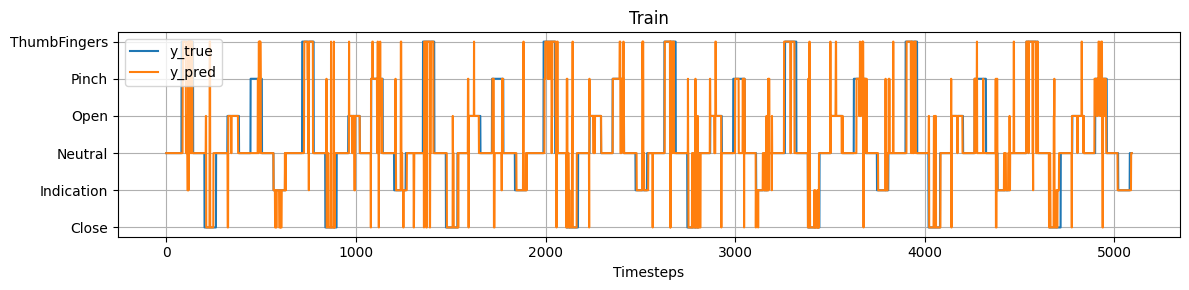

In [797]:
fig = plt.figure(figsize=(12, 3))
plt.plot(y_train, label='y_true')
plt.plot(preds_train, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

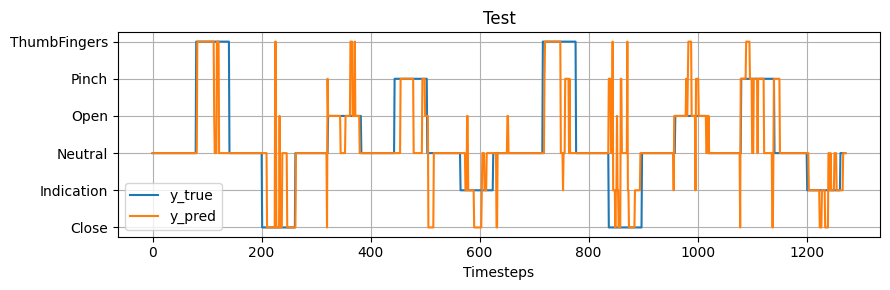

In [798]:
fig = plt.figure(figsize=(9, 3))
plt.plot(y_valid, label='y_true')
plt.plot(preds_valid, label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [799]:
print('Train preds metrics report:')
print(metrics.classification_report(
    y_train, preds_train, target_names=GESTURES, digits=4, zero_division=0))
print('-'*55)
print('Test preds metrics report:')
print(metrics.classification_report(
    y_valid, preds_valid, target_names=GESTURES, digits=4, zero_division=0))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, preds_valid.reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

Train preds metrics report:
              precision    recall  f1-score   support

       Close     0.8070    0.6639    0.7285       485
  Indication     0.8355    0.7942    0.8143       486
     Neutral     0.8220    0.9509    0.8818      2667
        Open     0.8690    0.8601    0.8645       486
       Pinch     0.7312    0.4215    0.5347       484
ThumbFingers     0.8005    0.6384    0.7103       484

    accuracy                         0.8199      5092
   macro avg     0.8109    0.7215    0.7557      5092
weighted avg     0.8157    0.8199    0.8098      5092

-------------------------------------------------------
Test preds metrics report:
              precision    recall  f1-score   support

       Close     0.5773    0.4590    0.5114       122
  Indication     0.6818    0.4959    0.5742       121
     Neutral     0.7793    0.9398    0.8521       665
        Open     0.8462    0.7273    0.7822       121
       Pinch     0.6421    0.5041    0.5648       121
ThumbFingers     0.74

,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,56,20,34,2,6,4
Indication,24,60,35,2,0,0
Neutral,15,6,625,7,12,0
Open,0,1,14,88,7,11
Pinch,2,0,47,4,61,7
ThumbFingers,0,1,47,1,9,64


### F1-weighted scores

#### Set 1
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set1_bl|set1_opt|1_bl_exp|1_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.7715|0.7889|(0.7725) (0.7629) (0.7580) (0.7881) (0.7754)|-|
|`LogisticRegression`|0.5438|0.5777|(0.5342) (0.8540) (0.8843) (0.8918) (0.8790)|-|
|`PassiveAggressive`|0.6912|0.6631|(0.6443) (0.9114) (0.9198) (0.9131) (0.8942)|-|
|`Perceptron`|0.5642|0.5642|(0.5271) (0.8771) (0.6292) (0.8342) (0.8224)|-|
|`Ridge`|0.4852|0.4901|(0.5032) (0.7674) (0.7853) (0.8732) (0.8384)|-|
|`SGD`|0.6954|0.5729|(0.4897) (0.8919) (0.9064) (0.8588) (0.8265)|-|
|`LinearSVC`|0.4921|0.6502|(0.5070) (0.8893) (0.9047) (0.9171) (0.9119)|-|
|`SVC`|0.8560|0.8871|(0.7542) (0.9022) (0.9024) (0.8797) (0.7960)|-|
|`KNeighbors`|0.9170|0.9153|(0.8395) (0.9179) (0.9265) (0.9218) (0.8473)|0.9286|
|`MLP`|0.8957|0.9273|(0.8990) (0.8975) (0.9180) (0.9263) (0.9035)|-|
|`DecisionTree`|0.8476|0.8366|(0.8522) (0.8485) (0.8156) (0.8285) (0.8203)|-|
|`AdaBoost`|0.8522|0.9096|(0.8339) (0.8323) (0.8090) (0.8319) (0.8228)|-|
|`Bagging`|0.8846|0.9072|(0.8983) (0.8959) (0.8702) (0.9042) (0.8827)|-|
|`ExtraTrees`|0.8809|0.8777|(0.9192) (0.8920) (0.8930) (0.8965) (0.9195)|-|
|`GradientBoosting`|0.9202|0.9146|(0.9024) (0.9164) (0.9041) (0.9116) (0.9179)|-|
|`RandomForest`|0.9046|0.9062|(0.9141) (0.9133) (0.9006) (0.9097) (0.9239)|-|
|`HistGradientBoosting`|0.9128|0.9072|(0.9092) (0.9070) (0.9004) (0.9275) (0.9225)|-|
|`XGB`|0.8985|0.9034|(0.9148) (0.8980) (0.8988) (0.9144) (0.9180)|-|
|`CatBoost`|0.9108|0.9147|(0.9212) (0.9142) (0.9168) (0.9320) (0.9302)|-|
---

#### Set 2
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set2_bl|set2_opt|2_bl_exp<br> (55) (300) (305) (350) (355)|2_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.6758|0.6756|(0.6732) (0.5950) (0.6073) (0.6488) (0.6487)|() () (0.6067) () ()|
|`LogisticRegression`|0.4887|0.4902|(0.5170) (0.7546) (0.7575) (0.7363) (0.7411)|() () () () ()|
|`PassiveAggressive`|0.4053|0.4838|(0.4458) (0.7170) (0.7667) (0.6894) (0.6768)|() () () () ()|
|`Perceptron`|0.5215|0.5215|(0.4857) (0.7002) (0.7496) (0.6640) (0.6766)|() () () () ()|
|`Ridge`|0.4685|0.4685|(0.4852) (0.7336) (0.7365) (0.7461) (0.7421)|() () () () ()|
|`SGD`|0.5304|0.5014|(0.5333) (0.7613) (0.7675) (0.7297) (0.7250)|() () () () ()|
|`LinearSVC`|0.4752|0.5548|(0.5007) (0.7718) (0.7748) (0.7528) (0.7666)|() () () () ()|
|`SVC`|0.7791|0.8022|(0.7801) (0.8142) (0.8048) (0.7905) (0.7977)|() () () () ()|
|`KNeighbors`|0.8098|0.8176|(0.8143) (0.7963) (0.7654) (0.8177) (0.8110)|() () () () ()|
|`MLP`|0.8292|0.8249|(0.7993) (0.8470) (0.8370) (0.8267) (0.8213)|() () () () ()|
|`DecisionTree`|0.7101|0.7209|(0.7125) (0.6662) (0.6991) (0.6560) (0.6629)|() () () () ()|
|`AdaBoost`|0.7037|0.8018|(0.6819) (0.6917) (0.6806) (0.6491) (0.6633)|() () () () ()|
|`Bagging`|0.7820|0.8145|(0.7896) (0.7870) (0.7877) (0.7422) (0.7583)|() () () () ()|
|`ExtraTrees`|0.8251|0.8226|(0.8222) (0.8218) (0.8220) (0.8312) (0.8346)|() () () () ()|
|`GradientBoosting`|0.7771|0.8073|(0.7838) (0.8204) (0.8254) (0.8269) (0.8160)|() () () () ()|
|`RandomForest`|0.8234|0.8216|(0.8170) (0.8337) (0.8517) (0.8350) (0.8433)|() () () () ()|
|`HistGradientBoosting`|0.8300|0.8131|(0.8118) (0.8481) (0.8558) (0.8296) (0.8457)|() () () () ()|
|`XGB`|0.8092|0.7821|(0.7967) (0.8546) (0.8552) (0.8212) (0.8280)|() () () () ()|
|`CatBoost`|0.8353|0.8421|(0.8313) (0.8530) (0.8677) (0.8554) (0.8613)|() () () () ()|
---

#### Set 3
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set3_bl|set3_opt|3_bl_exp|3_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.8930|0.8907|(0.8865) (0.9358) (0.9274) (0.9339) (0.9318)|() (0.9378) () () ()|
|`LogisticRegression`|0.8828|0.8935|(0.8932) (0.9016) (0.9074) (0.9055) (0.9117)|() () () () ()|
|`PassiveAggressive`|0.8996|0.8957|(0.8926) (0.9382) (0.9284) (0.9280) (0.9280)|() () () () ()|
|`Perceptron`|0.8934|0.8934|(0.8963) (0.9342) (0.9188) (0.9301) (0.9116)|() (0.9342) () () ()|
|`Ridge`|0.7349|0.7469|(0.8300) (0.8790) (0.8873) (0.8880) (0.8818)|() () () () ()|
|`SGD`|0.8976|0.8956|(0.9060) (0.9240) (0.9180) (0.9279) (0.9260)|() () () () ()|
|`LinearSVC`|0.8895|0.8935|(0.9057) (0.9179) (0.9200) (0.9240) (0.9260)|() () () () ()|
|`SVC`|0.8681|0.8914|(0.8723) (0.9217) (0.9012) (0.8723) (0.8744)|() () () () ()|
|`KNeighbors`|0.8565|0.8783|(0.8734) (0.9024) (0.9006) (0.8945) (0.9070)|() () () () ()|
|`MLP`|0.8758|0.8976|(0.8868) (0.9322) (0.9310) (0.9262) (0.9228)|() () () () ()|
|`DecisionTree`|0.8407|0.8749|(0.8479) (0.8916) (0.8473) (0.7725) (0.8368)|() () () () ()|
|`AdaBoost`|0.8426|0.8893|(0.8479) (0.9086) (0.8247) (0.8141) (0.8166)|() () () () ()|
|`Bagging`|0.8628|0.8759|(0.8651) (0.9099) (0.8721) (0.8364) (0.8756)|() () () () ()|
|`ExtraTrees`|0.8954|0.8685|(0.9032) (0.9318) (0.9276) (0.9277) (0.9295)|() () () () ()|
|`GradientBoosting`|0.8920|0.8869|(0.8755) (0.9144) (0.9240) (0.8734) (0.9124)|() () () () ()|
|`RandomForest`|0.8897|0.8724|(0.9055) (0.9299) (0.9277) (0.9207) (0.9321)|() () () () ()|
|`HistGradientBoosting`|0.8901|0.8721|(0.8956) (0.9338) (0.9358) (0.9344) (0.9241)|() () () () ()|
|`XGB`|0.9057|0.8862|(0.8938) (0.9338) (0.9340) (0.8799) (0.9298)|() () () () ()|
|`CatBoost`|0.9014|0.8934|(0.9055) (0.9358) (0.9336) (0.9301) (0.9319)|() () () () ()|
---

# Real-time inference

In [289]:
import time
import serial
from IPython.display import clear_output

## Inference Utils: Put your code here

In [785]:
def preprocessing(x, prev, sample_size=10, n_ftrs=5):
    # x - sample vector
    if prev is None:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        prev = x.reshape(1, -1)
        prev_scaled = std_scaler.transform(prev)
        # prev_approx = get_sliding_approximation(prev_scaled, n_ftrs=n_ftrs)
        prev_ar = create_AR_features(prev_scaled, p=n_ftrs)
        prev_ = np.hstack((prev_scaled, prev_ar)) # prev_approx, 
        prev_pca = pca.transform(prev_)
        y = prev_pca
    else:
        # x = np.delete(x.reshape(1, -1), bad_features, axis=1)
        prev = np.vstack((prev, x.reshape(1, -1)))
        if prev.shape[0] < sample_size:
            prev_scaled = std_scaler.transform(prev)
            # prev_approx = get_sliding_approximation(prev_scaled, n_ftrs=n_ftrs)
            prev_ar = create_AR_features(prev_scaled, p=n_ftrs)
            prev_ = np.hstack((prev_scaled, prev_ar)) # prev_approx, 
            prev_pca = pca.transform(prev_)
            y = get_convolve(prev_pca, M=10, tau=3, sym=True)[-1]
        else:
            volume = sample_size + n_ftrs
            if prev.shape[0] < volume:
                prev = np.vstack((np.zeros((volume - prev.shape[0], prev.shape[1])), prev))
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            else:
                prev = prev[1:]
                appr_prev = prev[:n_ftrs]
                prev_x = prev[n_ftrs:]
            prev_scaled = std_scaler.transform(prev_x)
            # prev_approx = get_sliding_approximation(
            #     prev_scaled, n_ftrs=5, prev=appr_prev)
            prev_ar = create_AR_features(prev_scaled, p=n_ftrs, prev=appr_prev)
            prev_ = np.hstack((prev_scaled, prev_ar)) # prev_approx, 
            prev_pca = pca.transform(prev_)
            y = get_convolve(prev_pca, M=10, tau=3, sym=True)[-1]
            
    return y.reshape(1, -1), prev


def inference(x):
    # y = model.predict_proba([x])[0]
    y = model.predict(x)
    
    return y


def postprocessing(x, prev, length=5):
    # if prev is None:
    #     y = x
    # else:
    #     y = x*0.1 + prev*0.9 # Holt-Winters filter

    if prev is None:
        prev = np.zeros((length,))
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
        
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    
    return y


# def commands(x):
#     cmd = vp.neutral_state.copy()
#     # for this mapping look at GESTURES
#     if x == 0: # 'Close'
#         cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 1: # 'Indication'
#         cmd.update({'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
#         return cmd
#     elif x == 2: # 'Neutral'
#         pass
#         return cmd
#     elif x == 3: # 'Open'
#         cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 4: # 'Pinch'
#         cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     elif x == 5: # 'ThumbFingers'
#         cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
#         return cmd
#     else:
#         return cmd

## Inference

### Offline (dataset)

In [786]:
df_sim = gestures.iloc[:, :52][int(X.shape[0] * 0.8)+1:]
target = y_shifted[int(X.shape[0] * 0.8)+1:]
print(df_sim.shape, target.shape)

(1272, 52) (1272,)


In [293]:
# Отключаем предупреждения DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

Текст предупреждения:<br>*DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)*

Строка кода, вызывающее предупреждение:<br>`prev[0] = x`

In [787]:
sample = df_sim.values[0]
[[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
sample_preprocessed, x_previous = preprocessing(omg_sample, None)
y_predicted = inference(sample_preprocessed)
y_postprocessed, y_previous = postprocessing(y_predicted, None, length=5)
y_previous

array([0, 0, 0, 0, 0])

In [800]:
# n_ftrs, m_ftrs = 5, len(OMG_CH)
LENGTH = 3
# approx_prev = np.zeros((n_ftrs+1, m_ftrs))
ts_diffs = []
x_previous = None

In [801]:
TIMEOUT = 0.2
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [[ts, cycle_ts], omg_sample] = np.array_split(sample, [2])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands = commands(y_postprocessed.argmax())
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=52, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        # print('INPUT:\n', s)
        print('SAMPLE:\n', sample)

        # sanity check: Sizes of SAMPLE=65, OMG=50
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
        print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
        print(y_postprocessed)
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\n{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [802]:
np.max(ts_diffs)

0.04500102996826172

In [803]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (1272, 50)
sample_preprocessed.shape = (1272, 1, 105)
y_predicted.shape = (1272, 1)
y_postprocessed.shape = (1272,)
y_commands.shape = (1272,)


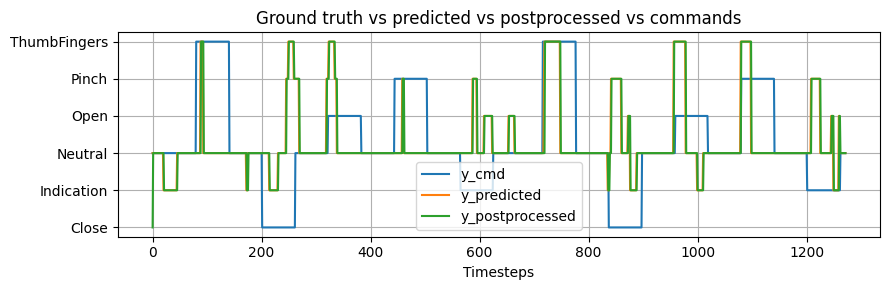

In [804]:
fig = plt.figure(figsize=(9, 3))

plt.plot(target, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].reshape(-1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [805]:
print(metrics.classification_report(
    target, y_dct['y_postprocessed'],
    target_names=GESTURES, digits=4,
    zero_division=0
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_valid, y_dct['y_postprocessed'].reshape(-1))
if not list(ct.index) == list(ct.columns):
    set1, set2 = set(ct.index), set(ct.columns)
    diff = set1.difference(set2)
    if len(diff) == 1:
        specific_index = list(ct.index).index(list(diff)[0])
        new_column_name = str(diff)
        ct.insert(specific_index, new_column_name, 0)
        # определяем название активностей
        ct.index = ct.columns = GESTURES
        display(ct)
    else:
        print('Более чем один жест моделью не распознается!')
else:
    ct.index = ct.columns = GESTURES
    display(ct)

              precision    recall  f1-score   support

       Close     0.0000    0.0000    0.0000       122
  Indication     0.1250    0.0826    0.0995       121
     Neutral     0.6182    0.9203    0.7396       665
        Open     0.0000    0.0000    0.0000       121
       Pinch     0.0435    0.0248    0.0316       121
ThumbFingers     0.3542    0.2787    0.3119       122

    accuracy                         0.5181      1272
   macro avg     0.1901    0.2177    0.1971      1272
weighted avg     0.3732    0.5181    0.4290      1272



,Close,Indication,Neutral,Open,Pinch,ThumbFingers
Close,0,30,53,4,25,10
Indication,0,10,65,21,25,0
Neutral,1,29,612,11,10,2
Open,0,11,73,0,6,31
Pinch,0,0,99,0,3,19
ThumbFingers,0,0,88,0,0,34


### F1-weighted scores

#### Set 1
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set1_bl|set1_opt|1_bl_exp|1_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.7525|0.7606|(0.7244) () () () (0.7180)|-|
|`LogisticRegression`|0.4635|0.4902|(0.4758) () () () (0.8522)|-|
|`PassiveAggressive`|0.6624|0.6151|(0.6207) () () () (0.8801)|-|
|`Perceptron`|0.5364|0.5364|(0.5142) () () () (0.7760)|-|
|`Ridge`|0.4167|0.4239|(0.4344) () () () (0.7682)|-|
|`SGD`|0.6441|0.5700|(0.4562) () () () (0.7817)|-|
|`LinearSVC`|0.4328|0.5690|(0.4456) () () () (0.9102)|-|
|`SVC`|0.8160|0.8729|(0.6844) () () () (0.7151)|-|
|`KNeighbors`|0.9183|0.9113|(0.8149) () () () (0.8259)|-|
|`MLP`|0.8962|0.9251|(0.8962) () () () (0.9001)|-|
|`DecisionTree`|0.8644|0.8288|(0.8356) () () () (0.8406)|-|
|`AdaBoost`|0.8546|0.9103|(0.8326) () () () (0.8351)|-|
|`Bagging`|0.8984|0.9180|(0.8809) () () () (0.8824)|-|
|`ExtraTrees`|0.8849|0.8818|(0.9086) () () () (0.9198)|-|
|`GradientBoosting`|0.9268|0.9253|(0.9057) () () () (0.9083)|-|
|`RandomForest`|0.9130|0.9069|(0.9183) () () () (0.9125)|-|
|`HistGradientBoosting`|0.9196|0.9115|(0.9158) () () () (0.9203)|-|
|`XGB`|0.9162|0.9059|(0.9137) () () () (0.9184)|-|
|`CatBoost`|0.9200|0.9231|(0.9317) () () () (0.9237)|-|
---

#### Set 2
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set2_bl|set2_opt|2_bl_exp|2_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.6149|0.6130|(0.6551) (0.5020) (0.5156) (0.2815) ()|-|
|`LogisticRegression`|0.4620|0.4610|(0.4851) (0.6739) (0.6683) (0.4290) ()|-|
|`PassiveAggressive`|0.3790|0.4788|(0.4209) (0.6910) (0.7604) () ()|-|
|`Perceptron`|0.4726|0.4726|(0.4769) (0.5937) (0.6958) () ()|-|
|`Ridge`|0.4424|0.4424|(0.4568) (0.6415) (0.6392) () ()|-|
|`SGD`|0.4799|0.4654|(0.5144) (0.7087) (0.7177) () ()|-|
|`LinearSVC`|0.4533|0.5089|(0.4811) (0.6973) (0.6982) () ()|-|
|`SVC`|0.7115|0.7441|(0.7094) (0.7508) (0.7690) () ()|-|
|`KNeighbors`|0.7736|0.7821|(0.7536) (0.7606) (0.7344) () ()|-|
|`MLP`|0.8249|0.8166|(0.7808) (0.8363) (0.8421) () ()|-|
|`DecisionTree`|0.6985|0.6899|(0.7215) (0.6281) (0.6741) () ()|-|
|`AdaBoost`|0.6817|0.7606|(0.6893) (0.6356) (0.6776) () ()|-|
|`Bagging`|0.7620|0.7731|(0.7610) (0.6899) (0.7171) () ()|-|
|`ExtraTrees`|0.7580|0.7674|(0.7583) (0.6740) (0.6725) () ()|-|
|`GradientBoosting`|0.7409|0.7576|(0.7535) (0.6793) (0.6913) () ()|-|
|`RandomForest`|0.7839|0.7835|(0.7878) (0.7058) (0.7439) () ()|-|
|`HistGradientBoosting`|0.7763|0.7835|(0.7829) (0.7995) (0.8368) () ()|-|
|`XGB`|0.7729|0.7215|(0.7848) (0.7930) (0.8304) () ()|-|
|`CatBoost`|0.8248|0.8188|(0.8199) (0.8089) (0.8269) () ()|-|
---

#### Set 3
| bl | bl_opt | exp*: (50+5) (300) (300+5) (300+50) (300+5+50) | exp opt |<br>
*Experiments with modified preprocessing

---
|model|set3_bl|set3_opt|3_bl_exp|3_opt_exp|
|-|-|-|-|-|
|`GaussianNB`|0.8953|0.8934|(0.8954) () () () (0.9134)|-|
|`LogisticRegression`|0.8992|0.3506|(0.9012) () () () (0.9073)|-|
|`PassiveAggressive`|0.3765|0.9135|(0.8878) () () () (0.9258)|-|
|`Perceptron`|0.3784|0.3784|(0.3791) () () () (0.3783)|-|
|`Ridge`|0.7019|0.7101|(0.7604) () () () (0.8712)|-|
|`SGD`|0.4272|0.9014|(0.4273) () () () (0.9092)|-|
|`LinearSVC`|0.3697|0.3439|(0.9193) () () () (0.9257)|-|
|`SVC`|0.8684|0.8952|(0.8724) () () () (0.8749)|-|
|`KNeighbors`|0.7027|0.8724|(0.8531) () () () (0.8761)|-|
|`MLP`|0.8853|0.9115|(0.9072) () () () (0.8975)|-|
|`DecisionTree`|0.8675|0.8789|(0.8902) () () () (0.9156)|-|
|`AdaBoost`|0.8676|0.8954|(0.8854) () () () (0.9145)|-|
|`Bagging`|0.9032|0.8780|(0.9094) () () () (0.9215)|-|
|`ExtraTrees`|0.9035|0.8647|(0.9031) () () () (0.9155)|-|
|`GradientBoosting`|0.9032|0.9052|(0.9032) () () () (0.9096)|-|
|`RandomForest`|0.9112|0.8728|(0.9132) () () () (0.9214)|-|
|`HistGradientBoosting`|0.9074|0.8718|(0.9112) () () () (0.9175)|-|
|`XGB`|0.9114|0.8891|(0.9131) () () () (0.9275)|-|
|`CatBoost`|0.9055|0.9052|(0.9132) () () () (0.9235)|-|
---

### Online (prosthesis or virtual hand)

In [110]:
# from copy import deepcopy
# import MotoricaInterface as mi; assert(mi.__version__=="0.0.3") # last time tested
# vp = mi.VirtualPhantomClient('localhost', 1755)

In [111]:
# !ls /dev/ttyUSB*

In [112]:
# TIMEOUT = 0.033
# DEBUG = True

# ser = None
# ser_port = None
# ser_port = '/dev/ttyUSB1'

# if ser_port is not None:
#     ser = serial.Serial(port=ser_port, baudrate=115200, timeout=1.0)
#     # time.sleep(0.2)

#     # ser.write('M0\r\n'.encode())
#     # time.sleep(0.1)

#     # # ser.write('S2\r\n'.encode())
#     # # time.sleep(0.1)

#     # ser.write('PT\r\n'.encode())
#     # time.sleep(0.1)
#     # ser.write('Pt\r\n'.encode())
#     # time.sleep(0.1)
#     # ser.flush()

#     # time.sleep(0.1)

In [113]:
# def parseline():
#     line = ser.readline().decode().replace('\n', '')
#     data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
#     return data

# ser.readline()
# while True:
#     data = parseline()
#     print(f"data len: {len(data)} |", list(data), end = '                                          \r')

In [114]:
# # flush buffers
# ser.reset_input_buffer()
# ser.read()

# i = 0;
# while(ser.in_waiting):
#     print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
#     ser.read_all()
#     time.sleep(0.005)
#     i+=1;
# ser.readline()
# ser.readline()
    
# i = 0
# ts_old = time.time()
# ts_diff = 0;

# ts_diffs = []
# x_previous = None
# y_previous = None

# pack = None

# prev_state = 'None'
# prev_idx = -1
# y_commands = vp.neutral_state.copy()

# while True:    
    
#     # [Data reading]
#     s = ser.readline()
#     ts_start = time.time()
    
#     try:
#         sample = s.decode().replace('\n', '')
#         data = np.array(list(filter(len, np.array(sample.split(" "))))).astype(float)
#         [[ts, cycle_ts], omg_sample] = np.array_split(data, [2])
        
#     except Exception as e:
#         print(e)
#     # [/Data Reading]
        
#     # [Data preprocessing]
#     sample_preprocessed = preprocessing(omg_sample)
#     # [/Data preprocessing]
    
#     # [Inference]
#     y_predicted         = inference(sample_preprocessed)
#     # [/Inference]
    
#     # [Inference Postprocessing]
#     y_postprocessed     = postprocessing(y_predicted, y_previous)
#     # [/Inference Postprocessing]
    
#     # [Commands composition]
#     y_commands          = commands(y_postprocessed.argmax())
#     # [/Commands composition]
    
#     # [Commands sending]
#     # pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
#     prot_idx = deepcopy(y_commands)
#     if (prot_idx!=prev_idx):
#         # socket_send(row.Command)
#         vp.send_cmd(**y_commands)
#         prev_idx = prot_idx
#     # [/Commands sending]
    
#     y_previous = y_postprocessed

    
#     if DEBUG:
#         clear_output(wait=True)

#         # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
#         print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
#         # print('INPUT:\n', s)
#         print('SAMPLE:\n', sample)

#         # sanity check: Sizes of SAMPLE=65, OMG=50
#         print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}')
#         print(f'TS: {ts}, CYCLE TS: {cycle_ts}')
#         print(y_postprocessed, GESTURES[y_postprocessed])
#         # print(y_commands)
#         # print(pack)
    
#     ts_diff = time.time() - ts_start
#     # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
#     ts_old = ts_start
#     i += 1 

# Draft

In [115]:
# crc_table = [
#     54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
#     111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
#     113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
#     179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
#     115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
#     88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
#     97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
#     45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
#     153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
#     114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
#     215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
#     0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
#     18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
#     57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
#     193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
#     213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
#     137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
#     67, 112, 109, 78, 114, 165, 244, 183, 121
# ];
    
# def get_crc(data, count):
#     result = 0x00
#     l = count
#     while (count>0):   
#         result = crc_table[result ^ data[l-count]]
#         count -= 1;
#     return result;

# def drv_abs_one(ser, control):
#     if ser is None:
#         return
#     pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
#     pack[-1] = get_crc(pack[1:], 9)
#     return (pack, ser.write(bytearray(pack)))

---